# Correcting Barium Records for 6 Arctic rivers

* This notebook is a summary of what I did in finding the relationship between fluvial Ba records and river discharge in 6 largest Arctic rivers.
* Updated on 2015/05/08, No more discharge issues, just correcting Ba records to a seasonal cycle.

# Content
1. [**Import modules & tools**](#Import-modules-&-tools)
1. [**Define functions**](#Define-functions)
1. [**Barium records**](#Barium-records)
  2. [Read datasets](#Read-datasets)
  2. [Combine datasets to series](#Combine-datasets-to-series)
  2. [Reconstruct to monthly mean values](#Reconstruct-to-monthly-mean-values)
1. [**Create Ba forcing**](#Create-Ba-forcing)
  2. [The "relative" values](#The-"relative"-values)
  2. [Fill missing values](#Fill-missing-values)
  2. [Plot the forcing Ba](#Plot-the-forcing-Ba)
1. [**Save-results**](#Save-results)

# Import modules and tools

In [1]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts
from Mat2Py import datenum2datetime, datetime2datenum_single 

In [2]:
import glob
import scipy.io
import datetime
import numpy as np
import matplotlib.pyplot as plt
#from seaborn import xkcd_rgb as xcolor
% matplotlib inline

In [3]:
reload(Nts)

<module 'NEMO_tools' from '_libs/NEMO_tools.pyc'>

# Define functions

In [4]:
def convert_list(dt):
        temp = np.zeros(len(dt))
        for i in range(len(dt)):
            temp[i] = datetime2datenum_single(dt[i])
        return temp

In [5]:
def daily2monmean(dt, data):
    '''
    =======================================================================
    Convert data in days to monthly mean series
                            ----- created on 2014/12/25, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data_dt, series, bin_count = daily2monmean(...)
    -----------------------------------------------------------------------
    Input:
            dt: A list of original data's datetime.datetime objects
            data: original data
    Output:
            data_dt: A list of monmean datetime.datetime objects
            data: monmean data
            bin_count: how many points fall into each months, 
                        data[i]=np.nan when bin_count[i]=0.
    ======================================================================= 
    '''
    import datetime
    import numpy as np
    from dateutil.relativedelta import relativedelta
    
    dt=sorted(dt) # increase order
    # Calculate the length of series
    L=(dt[-1].year-dt[0].year+1)*12
    series=np.zeros(L)
    bin_count=np.zeros(L)
    # Bin data points
    for i in range(len(dt)):
        hit=(dt[i].year-dt[0].year)*12+dt[i].month
        series[hit-1] += data[i] # "-1" because it is Python
        bin_count[hit-1] += 1 # count    
    for i in range(L):
        if bin_count[i] > 0:
            series[i]=series[i]/bin_count[i]
        if bin_count[i] == 0:
            series[i]=np.nan            
    # generate a corresponding datetime series
    data_dt=[datetime.datetime(dt[0].year, 01, 01)]
    step=relativedelta(months=1)    
    for i in range(L-1): # don't know why but it needs L-1, or the size will missmatch
        temp=data_dt[i]
        temp += step
        data_dt.append(temp)
    
    return data_dt, series, bin_count

In [6]:
def seasonal_character(dt, data):
    '''
    =======================================================================
    bin daily data into 12 months
                            ----- created on 2014/12/25, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        series, bin_count = seasonal_character(...)
    -----------------------------------------------------------------------
    Input:
            dt: A list of original data's datetime.datetime objects
            data: original data
    Output:
            data: data in 12 months
            bin_count: how many points fall into each months, 
                        data[i]=np.nan when bin_count[i]=0.
    ======================================================================= 
    '''
    #import datetime
    import numpy as np
    #from dateutil.relativedelta import relativedelta
    
    dt=sorted(dt) # increase order
    series=np.zeros(12)
    bin_count=np.zeros(12)
    # Bin data points
    for i in range(len(dt)):
        hit=dt[i].month
        series[hit-1] += data[i] # "-1" because it is Python
        bin_count[hit-1] += 1 # count    
    for i in range(12):
        if bin_count[i] > 0:
            series[i]=series[i]/bin_count[i]
        if bin_count[i] == 0:
            series[i]=np.nan        
    return series, bin_count

In [7]:
def int_between(begin, end, num_between):
    '''
    =======================================================================
    Use linear interpolation get values (equally distributed) between knowns
                            ----- created on 2015/05/08, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        out = seasonal_character(...)
    -----------------------------------------------------------------------
    Input:
            begin: x0
            end: x1
            num_between: how many points you want
    ======================================================================= 
    '''
    from scipy.interpolate import interp1d
    f = interp1d([0, 1], [begin, end])
    return f(np.linspace(0, 1, num_between+2))[1:-1]

In [8]:
def find_same_month(dt, data, month):
    '''
    =======================================================================
    Selecting data points in a certain month (but different years)
                            ----- created on 2014/12/25, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
    selected_data = seasonal_character(...)
    -----------------------------------------------------------------------
    Input:
            dt: A list of original data's datetime.datetime objects
            data: original data
            month: the month you want to select
    Output:
            selected_data: selected data
    ======================================================================= 
    '''
    out=[]
    for i in range(len(dt)):
        if dt[i].month==month:
            out=out+[data[i].tolist()]
    return np.array(out)
# plot mon bin
def plot_mon_bin(dt, data, ax):
    for i in range(1, 13):
        out=find_same_month(dt, data, i)
        ax.plot((i+0.35)*np.ones(np.size(out)), out, 'o', mfc=[0.94, 0.92, 0.84], mec='k', ms=10, mew=1.5)
        if i==6:
            ax.plot((i+0.35), out[0], 'o', mfc=[0.94, 0.92, 0.84], mec='k', ms=10, mew=1.5, label='Daily obs. overlaied in month')

In [9]:
def mutifig6(SIZE=(16, 12)):
    fig=plt.figure(figsize=SIZE)
    plt.subplots_adjust(hspace = 0.25)
    ax1=plt.subplot2grid((6, 1), (0, 0), colspan=6, rowspan=1)
    ax2=plt.subplot2grid((6, 1), (1, 0), colspan=6, rowspan=1)
    ax3=plt.subplot2grid((6, 1), (2, 0), colspan=6, rowspan=1)
    ax4=plt.subplot2grid((6, 1), (3, 0), colspan=6, rowspan=1)
    ax5=plt.subplot2grid((6, 1), (4, 0), colspan=6, rowspan=1)
    ax6=plt.subplot2grid((6, 1), (5, 0), colspan=6, rowspan=1)
    ax = fig.add_subplot(111)  
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
    AX = [ax1, ax2, ax3, ax4, ax5, ax6, ax]
    return fig, AX

In [10]:
def axis_to_fig(axis):
    fig = axis.figure
    def transform(coord):
        return fig.transFigure.inverted().transform(
            axis.transAxes.transform(coord))
    return transform

def add_sub_axes(axis, rect):
    fig = axis.figure
    left, bottom, width, height = rect
    trans = axis_to_fig(axis)
    figleft, figbottom = trans((left, bottom))
    figwidth, figheight = trans([width,height]) - trans([0,0])
    return fig.add_axes([figleft, figbottom, figwidth, figheight])

In [11]:
Mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [12]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran
SB=[0.06, 0.05, 0.03]    # Smokey Black
AFB = [0.36, 0.54, 0.66] # Air Force Blue
AG = [0.55, 0.71, 0.0]   # Apple Green
AZ = [0.0, 0.5, 1.0]     # Azure
CB = [0.37, 0.62, 0.63]  # Cadet blue
SP = [1.0, 0.72, 0.77]   # Sakura
CamB = [0.64, 0.76, 0.68]# Cambridge blue
DC = [0.0, 0.55, 0.55]   # Dark cyan
DE = [0.08, 0.38, 0.74]  # Denim
BB = [0.54, 0.81, 0.94]  # Baby blue

# Barium records

Datasets are downloaded from <a href='http://www.arcticgreatrivers.org/data'>**Arctic Great River Observatory**</a>. All datasets have been preprocessed in MATLAB.

The unit is nM (1E-6 mol/L).

**Locations of Observatories**

<table align="left">
<tr>
<th>River</th>
<th>Station</th>
<th>Longitude</th>
<th>Latitude</th>
</tr>
<tr>
<td>Lena</td>
<td>Zhigansk</td>
<td>123°22' E</td>
<td>66°46' N</td>
</tr>
<tr>
<td>Kolyma</td>
<td>Cherskiy</td>
<td>161°18' E</td>
<td>68°45' N</td>
</tr>
<tr>
<td>Yenisey</td>
<td>Dudinka</td>
<td>86°09' E</td>
<td>69°23' N</td>
</tr>
<tr>
<td>Mackenzie</td>
<td>Tsiigehtchic / Inuvik</td>
<td>133°45' W / 133°42' W</td>
<td>67°26' N / 68°20' N</td>
</tr>
<tr>
<td>Ob'</td>
<td>Salekhard</td>
<td>66°36' E</td>
<td>66°31' N</td>
</tr>
<tr>
<td>Yukon</td>
<td>Pilot Station</td>
<td>162°52' W</td>
<td>61°56' N</td>
</tr>
</table>

## Read datasets

** PARTNERS [L. W. Cooper et al., Geophys. Res. Lett., 2008] **

In [13]:
PARTNERS_name=glob.glob('_data/Samples/PARTNERS/*Barium.mat')
print("found file: \n{}".format(PARTNERS_name))
PARTNERS_obj=scipy.io.loadmat(PARTNERS_name[0])

found file: 
['_data/Samples/PARTNERS\\PATRNERS_Barium.mat']


In [14]:
PARTNERS_Lena=PARTNERS_obj['Lena']
PARTNERS_Kolyma=PARTNERS_obj['Kolyma']
PARTNERS_Yenisey=PARTNERS_obj['Yenisey']
PARTNERS_Mackenzie=PARTNERS_obj['Mackenzie']
PARTNERS_Ob=PARTNERS_obj['Ob']
PARTNERS_Yukon=PARTNERS_obj['Yukon']

** Arctic-GRO **

In [15]:
AGRO_name=glob.glob('_data/Samples/Arctic-GRO/*Barium.mat')
print("found file: \n{}".format(AGRO_name))
AGRO_obj=scipy.io.loadmat(AGRO_name[0])

found file: 
['_data/Samples/Arctic-GRO\\GRO_Barium.mat']


In [16]:
AGRO_Lena=AGRO_obj['Lena']
AGRO_Kolyma=AGRO_obj['Kolyma']
AGRO_Yenisey=AGRO_obj['Yenisey']
AGRO_Mackenzie=AGRO_obj['Mackenzie']
AGRO_Ob=AGRO_obj['Ob']
AGRO_Yukon=AGRO_obj['Yukon']

## Combine datasets to series

Combine datetime.datetime objects

In [17]:
Lena_time=datenum2datetime(PARTNERS_Lena[:, 0]) + datenum2datetime(AGRO_Lena[:, 0])
Kolyma_time=datenum2datetime(PARTNERS_Kolyma[:, 0]) + datenum2datetime(AGRO_Kolyma[:, 0])
Yenisey_time=datenum2datetime(PARTNERS_Yenisey[:, 0]) + datenum2datetime(AGRO_Yenisey[:, 0])
Mackenzie_time=datenum2datetime(PARTNERS_Mackenzie[:, 0]) + datenum2datetime(AGRO_Mackenzie[:, 0])
Ob_time=datenum2datetime(PARTNERS_Ob[:, 0]) + datenum2datetime(AGRO_Ob[:, 0])
Yukon_time=datenum2datetime(PARTNERS_Yukon[:, 0]) + datenum2datetime(AGRO_Yukon[:, 0])

Combine Ba records

In [18]:
Lena_Ba=np.hstack((PARTNERS_Lena[:, 1], AGRO_Lena[:, 1]))
Kolyma_Ba=np.hstack((PARTNERS_Kolyma[:, 1], AGRO_Kolyma[:, 1]))
Yenisey_Ba=np.hstack((PARTNERS_Yenisey[:, 1], AGRO_Yenisey[:, 1]))
Mackenzie_Ba=np.hstack((PARTNERS_Mackenzie[:, 1], AGRO_Mackenzie[:, 1]))
Ob_Ba=np.hstack((PARTNERS_Ob[:, 1], AGRO_Ob[:, 1]))
Yukon_Ba=np.hstack((PARTNERS_Yukon[:, 1], AGRO_Yukon[:, 1]))

## Reconstruct to monthly mean values

Bin raw data to monthly mean values

In [19]:
Lena_monmean, Lena_Ba_monmean, Lena_bin = daily2monmean(Lena_time, Lena_Ba)
Kolyma_monmean, Kolyma_Ba_monmean, Kolyma_bin = daily2monmean(Kolyma_time, Kolyma_Ba)
Yenisey_monmean, Yenisey_Ba_monmean, Yenisey_bin = daily2monmean(Yenisey_time, Yenisey_Ba)
Mackenzie_monmean, Mackenzie_Ba_monmean, Mackenzie_bin = daily2monmean(Mackenzie_time, Mackenzie_Ba)
Ob_monmean, Ob_Ba_monmean, Ob_bin = daily2monmean(Ob_time, Ob_Ba)
Yukon_monmean, Yukon_Ba_monmean, Yukon_bin = daily2monmean(Yukon_time, Yukon_Ba)

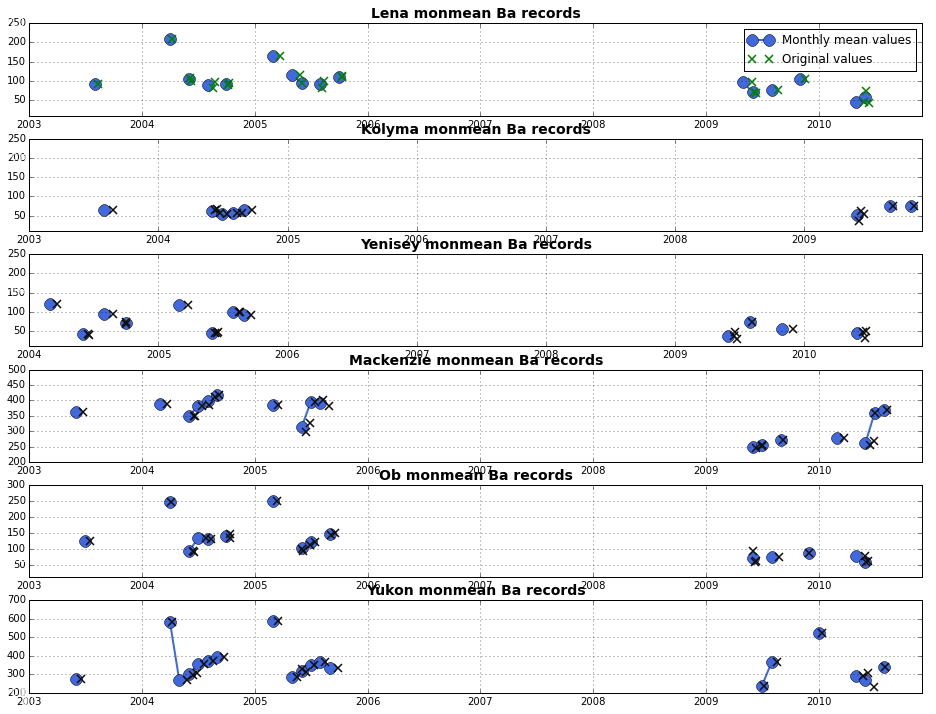

In [20]:
fig, AX = mutifig6()
for i in range(6):
    AX[i].grid()
#
AX[0].plot(Lena_monmean, Lena_Ba_monmean, 'o-', c=RB, ms=12, lw=2, label='Monthly mean values')
AX[0].plot(Lena_time, Lena_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2, label='Original values')
AX[0].set_xlim(Lena_monmean[0], Lena_monmean[-1]); AX[0].set_ylim(10, 250)
AX[0].set_title('Lena monmean Ba records', fontsize=14, fontweight='bold')
AX[0].legend(loc=1)
#
AX[1].plot(Kolyma_monmean, Kolyma_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[1].plot(Kolyma_time, Kolyma_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[1].set_xlim(Kolyma_monmean[0], Kolyma_monmean[-1]); AX[1].set_ylim(10, 250)
AX[1].set_title('Kolyma monmean Ba records', fontsize=14, fontweight='bold')
#
AX[2].plot(Yenisey_monmean, Yenisey_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[2].plot(Yenisey_time, Yenisey_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[2].set_xlim(Yenisey_monmean[0], Yenisey_monmean[-1]); AX[2].set_ylim(10, 250)
AX[2].set_title('Yenisey monmean Ba records', fontsize=14, fontweight='bold')
#
AX[3].plot(Mackenzie_monmean, Mackenzie_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[3].plot(Mackenzie_time, Mackenzie_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[3].set_xlim(Mackenzie_monmean[0], Mackenzie_monmean[-1]); AX[3].set_ylim(200, 500)
AX[3].set_title('Mackenzie monmean Ba records', fontsize=14, fontweight='bold')
#
AX[4].plot(Ob_monmean, Ob_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[4].plot(Ob_time, Ob_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[4].set_xlim(Ob_monmean[0], Ob_monmean[-1]); AX[4].set_ylim(10, 300)
AX[4].set_title('Ob monmean Ba records', fontsize=14, fontweight='bold')
#
AX[5].plot(Yukon_monmean, Yukon_Ba_monmean, 'o-', c=RB, ms=12, lw=2)
AX[5].plot(Yukon_time, Yukon_Ba, 'x', c=SB, ms=8, mew=1.5, lw=2)
AX[5].set_xlim(Yukon_monmean[0], Yukon_monmean[-1]); AX[5].set_ylim(200, 700)
AX[5].set_title('Yukon monmean Ba records', fontsize=14, fontweight='bold')

# Create Ba forcing

In [21]:
Lena_Ba_seasonal, Lena_bin_count_seasonal = seasonal_character(Lena_time, Lena_Ba)
Kolyma_Ba_seasonal, _ = seasonal_character(Kolyma_time, Kolyma_Ba)
Yenisey_Ba_seasonal, _ = seasonal_character(Yenisey_time, Yenisey_Ba)
Mackenzie_Ba_seasonal, Mackenzie_bin_count_seasonal = seasonal_character(Mackenzie_time, Mackenzie_Ba)
Ob_Ba_seasonal, _ = seasonal_character(Ob_time, Ob_Ba)
Yukon_Ba_seasonal, _ = seasonal_character(Yukon_time, Yukon_Ba)

In [22]:
t = np.arange(1, 13)

## The "relative" values

In [23]:
allBa = np.empty([6, 12])
allBa[0, :] = Lena_Ba_seasonal/np.nanmean(Lena_Ba_seasonal)
allBa[1, :] = Kolyma_Ba_seasonal/np.nanmean(Kolyma_Ba_seasonal)
allBa[2, :] = Yenisey_Ba_seasonal/np.nanmean(Yenisey_Ba_seasonal)
allBa[3, :] = Mackenzie_Ba_seasonal/np.nanmean(Mackenzie_Ba_seasonal)
allBa[4, :] = Ob_Ba_seasonal/np.nanmean(Ob_Ba_seasonal)
allBa[5, :] = Yukon_Ba_seasonal/np.nanmean(Yukon_Ba_seasonal)

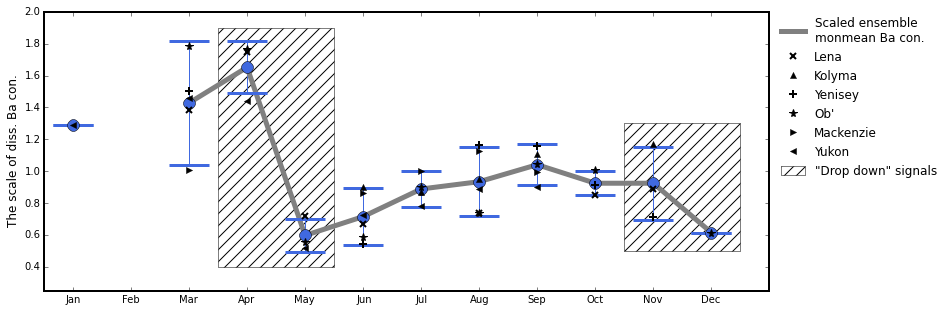

In [32]:
from matplotlib.patches import Rectangle
meanBa = np.nanmean(allBa, 0); maxBa = np.nanmax(allBa, 0); minBa = np.nanmin(allBa, 0)
errbar = (maxBa-minBa)/2; errbar[minBa==maxBa]=np.nan
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(t, meanBa, '-', color='gray', linewidth=5, label='Scaled ensemble\nmonmean Ba con.')
ax.add_patch(Rectangle((3.5, 0.4), 2, 1.5, facecolor='None', hatch='//', linewidth=0.5, label='"Drop down" signals'))
ax.add_patch(Rectangle((10.5, 0.5), 2, 0.8, facecolor='None', hatch='//', linewidth=0.5))
ax.errorbar(t, meanBa, yerr=(maxBa-minBa)/2, fmt='o', ms=12, mfc=RB, ecolor=RB, capthick=3, capsize=20);
ax.plot(t, allBa[0, :].T, 'x', ms=6, mew=2, color='k', label = 'Lena');
ax.plot(t, allBa[1, :].T, '^', ms=6, mew=0.5, color='k', label = 'Kolyma');
ax.plot(t, allBa[2, :].T, '+', ms=8, mew=2, color='k', label = 'Yenisey');
ax.plot(t, allBa[4, :].T, '*', ms=8, mew=1, color='k', label = "Ob'");
ax.plot(t, allBa[3, :].T, '>', ms=6, mew=0.5, color='k', label = 'Mackenzie');
ax.plot(t, allBa[5, :].T, '<', ms=6, mew=0.5, color='k', label = 'Yukon');
# ax.set_title('Monthly mean Ba/Annual mean Ba', fontsize=14, fontweight='bold')
LG = ax.legend(numpoints=1, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.); LG.draw_frame(False) 
#ax.grid(); 
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_ylabel('The scale of diss. Ba con.', fontsize=12)
ax.set_xlim(0.5, 13); ax.set_ylim(0.25, 2)
ax.set_xticks(range(1, 13)); ax.set_xticklabels(Mon);
fig.savefig('Publish/Barium_1.eps', dpi=600, orientation='portrait', papertype='a4', format='eps',
            transparent=False, bbox_inches='tight', pad_inches=0)

## Fill missing values

In [28]:
# Lena
Lena_Ba_re = np.copy(Lena_Ba_seasonal)
Lena_Ba_re[-1] = meanBa[-1]*np.nanmean(Lena_Ba_seasonal)
Lena_Ba_re[~np.isnan(Lena_Ba_seasonal)]=np.nan

Lena_Ba_int = np.copy(Lena_Ba_seasonal)
Lena_Ba_int[0:2] = int_between(Lena_Ba_re[-1], Lena_Ba_seasonal[2], 2)
Lena_Ba_int[6] = int_between(Lena_Ba_seasonal[5], Lena_Ba_seasonal[7], 1)
Lena_Ba_int[8] = int_between(Lena_Ba_seasonal[7], Lena_Ba_seasonal[9], 1)
Lena_Ba_nemo = np.copy(Lena_Ba_int); Lena_Ba_nemo[-1] = Lena_Ba_re[-1]
Lena_Ba_int[~np.isnan(Lena_Ba_seasonal)]=np.nan
# Kolyma
Kolyma_Ba_re = np.copy(Kolyma_Ba_seasonal)
Kolyma_Ba_re[3:5] = meanBa[3:5]*np.nanmean(Kolyma_Ba_seasonal)
Kolyma_Ba_re[-1] = meanBa[-1]*np.nanmean(Kolyma_Ba_seasonal)
Kolyma_Ba_re[~np.isnan(Kolyma_Ba_seasonal)]=np.nan

Kolyma_Ba_int = np.copy(Kolyma_Ba_seasonal)
Kolyma_Ba_int[0:3] = int_between(Kolyma_Ba_re[-1], Kolyma_Ba_re[3], 3)
Kolyma_Ba_int[9] = int_between(Kolyma_Ba_seasonal[8], Kolyma_Ba_seasonal[10], 1)
Kolyma_Ba_nemo = np.copy(Kolyma_Ba_int); 
Kolyma_Ba_nemo[3:5] = Kolyma_Ba_re[3:5]; 
Kolyma_Ba_nemo[-1] = Kolyma_Ba_re[-1]
Kolyma_Ba_int[~np.isnan(Kolyma_Ba_seasonal)]=np.nan
# Yenisey
Yenisey_Ba_re = np.copy(Yenisey_Ba_seasonal)
Yenisey_Ba_re[3:5] = meanBa[3:5]*np.nanmean(Yenisey_Ba_seasonal)
Yenisey_Ba_re[-1] = meanBa[-1]*np.nanmean(Yenisey_Ba_seasonal)
Yenisey_Ba_re[~np.isnan(Yenisey_Ba_seasonal)]=np.nan

Yenisey_Ba_int = np.copy(Yenisey_Ba_seasonal)
Yenisey_Ba_int[0:2] = int_between(Yenisey_Ba_re[-1], Yenisey_Ba_seasonal[2], 2)
Yenisey_Ba_int[6] = int_between(Yenisey_Ba_seasonal[5], Yenisey_Ba_seasonal[7], 1)
Yenisey_Ba_nemo = np.copy(Yenisey_Ba_int); 
Yenisey_Ba_nemo[3:5] = Yenisey_Ba_re[3:5]; 
Yenisey_Ba_nemo[-1] = Yenisey_Ba_re[-1]
Yenisey_Ba_int[~np.isnan(Yenisey_Ba_seasonal)]=np.nan
# Mackenzie
Mackenzie_Ba_re = np.copy(Mackenzie_Ba_seasonal)
Mackenzie_Ba_re[3:5] = meanBa[3:5]*np.nanmean(Mackenzie_Ba_seasonal)
Mackenzie_Ba_re[-1] = meanBa[-1]*np.nanmean(Mackenzie_Ba_seasonal)
Mackenzie_Ba_re[~np.isnan(Mackenzie_Ba_seasonal)]=np.nan

Mackenzie_Ba_int = np.copy(Mackenzie_Ba_seasonal)
Mackenzie_Ba_int[0:2] = int_between(Mackenzie_Ba_re[-1], Mackenzie_Ba_seasonal[2], 2)
Mackenzie_Ba_int[9:11] = int_between(Mackenzie_Ba_seasonal[8], Mackenzie_Ba_re[-1], 2)
Mackenzie_Ba_nemo = np.copy(Mackenzie_Ba_int); 
Mackenzie_Ba_nemo[3:5] = Mackenzie_Ba_re[3:5]; 
Mackenzie_Ba_nemo[-1] = Mackenzie_Ba_re[-1]
Mackenzie_Ba_int[~np.isnan(Mackenzie_Ba_seasonal)]=np.nan
# Ob
Ob_Ba_int = np.copy(Ob_Ba_seasonal)
Ob_Ba_int[0:2] = int_between(Ob_Ba_seasonal[-1], Ob_Ba_seasonal[2], 2)
Ob_Ba_int[10] = int_between(Ob_Ba_seasonal[9], Ob_Ba_seasonal[11], 1)
Ob_Ba_nemo = np.copy(Ob_Ba_int)
Ob_Ba_int[~np.isnan(Ob_Ba_seasonal)]=np.nan
# Yukon
Yukon_Ba_re = np.copy(Yukon_Ba_seasonal)
Yukon_Ba_re[-1] = meanBa[-1]*np.nanmean(Yukon_Ba_seasonal)
Yukon_Ba_re[~np.isnan(Yukon_Ba_seasonal)]=np.nan

Yukon_Ba_int = np.copy(Yukon_Ba_seasonal)
Yukon_Ba_int[1] = int_between(Yukon_Ba_seasonal[0], Yukon_Ba_seasonal[2], 1)
Yukon_Ba_int[9:11] = int_between(Yukon_Ba_seasonal[8], Yukon_Ba_re[-1], 2)
Yukon_Ba_nemo = np.copy(Yukon_Ba_int); Yukon_Ba_nemo[-1] = Yukon_Ba_re[-1]
Yukon_Ba_int[~np.isnan(Yukon_Ba_seasonal)]=np.nan

## Plot the forcing Ba

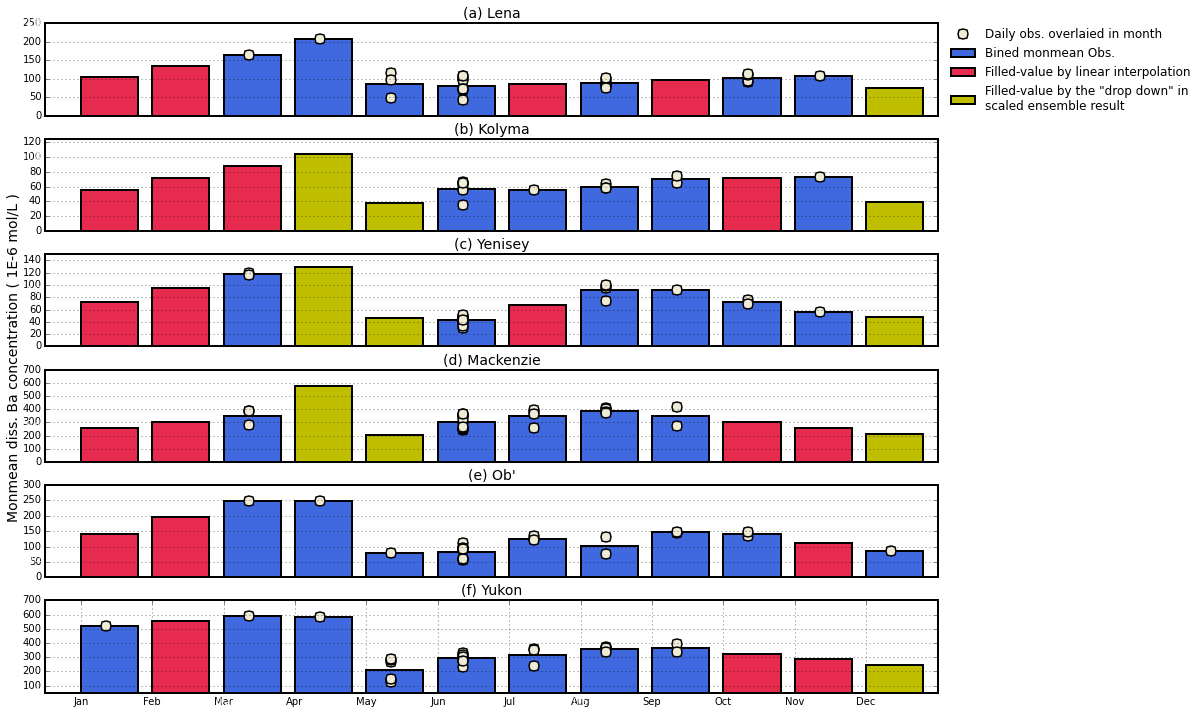

In [29]:
fig, AX = mutifig6()
for i in range(6):
    AX[i].grid(); AX[i].set_xticks(t); AX[i].set_xlim(0.5, 13)
    [i.set_linewidth(2) for i in AX[i].spines.itervalues()]
# Lena
plot_mon_bin(Lena_time, Lena_Ba, AX[0]);
AX[0].bar(t, Lena_Ba_seasonal, color=RB, linewidth=2, label='Bined monmean Obs.'); 
AX[0].bar(t, Lena_Ba_int, color=AM, linewidth=2, label='Filled-value by linear interpolation')
AX[0].bar(t, Lena_Ba_re, color='y', linewidth=2, label='Filled-value by the "drop down" in\nscaled ensemble result')
AX[0].set_ylim(0, 250); AX[0].set_title('(a) Lena', fontsize=14)#, fontweight='bold')
LG = AX[0].legend(numpoints=1, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.); LG.draw_frame(False) 
AX[0].xaxis.set_major_locator(plt.NullLocator())
# Kolyma
plot_mon_bin(Kolyma_time, Kolyma_Ba, AX[1])
AX[1].bar(t, Kolyma_Ba_seasonal, color=RB, linewidth=2)
AX[1].bar(t, Kolyma_Ba_int, color=AM, linewidth=2); 
AX[1].bar(t, Kolyma_Ba_re, color='y', linewidth=2); 
AX[1].set_ylim(0, 125); AX[1].set_title('(b) Kolyma', fontsize=14)#, fontweight='bold')
AX[1].xaxis.set_major_locator(plt.NullLocator())
# Yenisey
plot_mon_bin(Yenisey_time, Yenisey_Ba, AX[2])
AX[2].bar(t, Yenisey_Ba_seasonal, color=RB, linewidth=2)
AX[2].bar(t, Yenisey_Ba_int, color=AM, linewidth=2); 
AX[2].bar(t, Yenisey_Ba_re, color='y', linewidth=2); 
AX[2].set_ylim(0, 150); AX[2].set_title('(c) Yenisey', fontsize=14)#, fontweight='bold')
AX[2].xaxis.set_major_locator(plt.NullLocator())
# Mackenzie
plot_mon_bin(Mackenzie_time, Mackenzie_Ba, AX[3])
AX[3].bar(t, Mackenzie_Ba_seasonal, color=RB, linewidth=2)
AX[3].bar(t, Mackenzie_Ba_int, color=AM, linewidth=2);
AX[3].bar(t, Mackenzie_Ba_re, color='y', linewidth=2);
AX[3].set_ylim(0, 700); AX[3].set_title('(d) Mackenzie', fontsize=14)#, fontweight='bold')
AX[3].xaxis.set_major_locator(plt.NullLocator())
# Ob
plot_mon_bin(Ob_time, Ob_Ba, AX[4])
AX[4].bar(t, Ob_Ba_seasonal, color=RB, linewidth=2); 
AX[4].bar(t, Ob_Ba_int, color=AM, linewidth=2);
AX[4].set_ylim(0, 300); AX[4].set_title("(e) Ob'", fontsize=14)#, fontweight='bold')
AX[4].xaxis.set_major_locator(plt.NullLocator())
# Yukon
plot_mon_bin(Yukon_time, Yukon_Ba, AX[5])
AX[5].bar(t, Yukon_Ba_seasonal, color=RB, linewidth=2)
AX[5].bar(t, Yukon_Ba_int, color=AM, linewidth=2);
AX[5].bar(t, Yukon_Ba_re, color='y', linewidth=2);
AX[5].set_ylim(50, 700); AX[5].set_title('(f) Yukon', fontsize=14)#, fontweight='bold')
AX[5].set_xticks(range(1, 13)); AX[5].set_xticklabels(Mon);

AX[6].set_ylabel('Monmean diss. Ba concentration ( 1E-6 mol/L )', fontsize=14)
fig.savefig('Publish/Barium_2.eps', dpi=600, orientation='portrait', papertype='a4', format='eps',
            transparent=False, bbox_inches='tight', pad_inches=0)

# Save results

In [48]:
save_var = { 'Lena_Ba_nemo': np.squeeze(Lena_Ba_nemo),\
             'Kolyma_Ba_nemo': np.squeeze(Kolyma_Ba_nemo),\
             'Yenisey_Ba_nemo': np.squeeze(Yenisey_Ba_nemo),\
             'Mackenzie_Ba_nemo': np.squeeze(Mackenzie_Ba_nemo),\
             'Ob_Ba_nemo': np.squeeze(Ob_Ba_nemo),\
             'Yukon_Ba_nemo': np.squeeze(Yukon_Ba_nemo)
            }
scipy.io.savemat('_data/Exchange/River_Ba_nemo.mat', mdict=save_var)